Code written by: Billy Atkinson (watkinson@umces.edu) \
Paper Citation: Mason, E., A. Pascual, and J. C. McWilliams, 2014: A new sea surface height–based code for oceanic mesoscale eddy tracking. J. Atmos. Oceanic Technol., 31, 1181–1188, doi:10.1175/JTECH-D-14-00019.1. \
Source Code: __[Pixels inside/outside Eddies Documentation](https://py-eddy-tracker.readthedocs.io/en/latest/python_module/06_grid_manipulation/pet_hide_pixel_out_eddies.html#sphx-glr-python-module-06-grid-manipulation-pet-hide-pixel-out-eddies-py)__ \
Date of last revision: 01/05/2023 \
This code masks data outside the effective contour (outermost edge) of an eddy and the inner portion of the eddy comprising the eddy center

In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4 as nc
import datetime as dt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from scipy.stats import linregress
import numpy.ma as ma
import glob
import os
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.observations.observation import EddiesObservations

In [2]:
from matplotlib import pyplot as plt
from numpy import cos, linspace, radians, sin

from py_eddy_tracker import data
from py_eddy_tracker.generic import coordinates_to_local, local_to_coordinates
from py_eddy_tracker.observations.observation import EddiesObservations
from py_eddy_tracker.poly import fit_circle_, fit_ellipse

def build_circle(x0, y0, r):
    angle = radians(linspace(0, 360, 50))
    x_norm, y_norm = cos(angle), sin(angle)
    return local_to_coordinates(x_norm * r, y_norm * r, x0, y0)


def build_ellipse(x0, y0, a, b, theta):
    angle = radians(linspace(0, 360, 50))
    x = a * cos(theta) * cos(angle) - b * sin(theta) * sin(angle)
    y = a * sin(theta) * cos(angle) + b * cos(theta) * sin(angle)
    return local_to_coordinates(x, y, x0, y0)

In [75]:
#cycl_eddy_mask(cycl,file,variable,inside,outside,title,vmin,vmax,cb_label):
sat_files = sorted(glob.glob('/data/watkinson/Fall2022/Sat_data/1day_regrid/*.nc'))
#sat_files = sat_files[0:5]
#print(len(sat_files))
anti_files = sorted(glob.glob('/data/watkinson/Fall2022/Eddy_data/GoM_tuned_eddies/Anticyclonic/Anticyclonic_*.nc'))
#anti_files = anti_files[:1454]
anti_files = anti_files[:365]
#print(len(anti_files))
cycl_files = sorted(glob.glob('/data/watkinson/Fall2022/Eddy_data/GoM_tuned_eddies/Cyclonic/Cyclonic_*.nc'))
#cycl_files = cycl_files[:1454]
cycl_files = cycl_files[:365]

#print(len(cycl_files))


cycl_chlor_mean = list()
anti_chlor_mean = list()

n=0
#while n < len(sat_files):
while n < len(anti_files):
#cycl_eddy_mask(c,sat_data,"chlor_a",False,True,"Chlorophyll Concentration Inside of Eddies",0,.2,"Chlorophyl(mg * $m^{-3}$)'")
######set plotting parameters
    from matplotlib.path import Path
    from numpy import ones
    from py_eddy_tracker.poly import create_vertice
    
    a = EddiesObservations.load_file(anti_files[n])
    ######Cyclonic data

    c = EddiesObservations.load_file(cycl_files[n])
    #print(c)


    ###### Sat data
    sat_data = RegularGridDataset((sat_files[n]),
        "lon",
        "lat")
    
    from matplotlib.path import Path
    from numpy import ones
    from py_eddy_tracker.poly import create_vertice
    x_name_anti, y_name_anti = c.intern(False)# We will use the outter effective contour and not the inner speed contour
    #print(x_name_anti[0])
    adt_anti = sat_data.grid("chlor_a")
    #print(adt_anti)
    mask_anti = ones(adt_anti.shape, dtype="bool")#creates boolean array to use in masking values for anticyclonic eddies
    mask_anti2 = ones(adt_anti.shape, dtype="bool")
    ######takes the vertice points that defines the eddy edge and finds i,j pixels outside of those vertices

    for eddy in c:
        sat_data = RegularGridDataset((sat_files[n]),"lon","lat")
        adt_anti = sat_data.grid("chlor_a")
        mask_anti = ones(adt_anti.shape, dtype="bool")#creates boolean array to use in masking values for anticyclonic eddies
        i, j = Path(create_vertice(eddy[x_name_anti], eddy[y_name_anti])).pixels_in(sat_data)
        mask_anti[i, j] = False
        adt_anti.mask[:] = mask_anti
        
        mask_anti2 = ones(adt_anti.shape, dtype="bool")
        xs, ys = eddy[x_name_anti], eddy[y_name_anti]
        x0_, y0_ = xs.mean(), ys.mean()
        x_, y_ = coordinates_to_local(xs, ys, x0_, y0_)
        x0, y0, a, b, theta = fit_ellipse(x_, y_)
        x0, y0 = local_to_coordinates(x0, y0, x0_, y0_)
        w=-2*(1000)+a
        h=-2*(1000)+b
        z,z0= build_ellipse(x0, y0, w, h, theta)
        i2, j2 = Path(create_vertice(z, z0)).pixels_in(sat_data)
        mask_anti2[i2, j2] = False
        adt_anti.mask[:] += ~mask_anti2
        adt_anti = np.transpose(adt_anti)
        adt_anti = ma.masked_where(adt_anti==0,adt_anti)
        mean_anti = np.nanmean(adt_anti)
        #mean_anti = np.mean(adt_anti)
        mean_anti = np.atleast_1d(np.array(mean_anti))
        anti_chlor_mean = np.concatenate([anti_chlor_mean,mean_anti])
    n = n + 1

We assume pixel position of grid is centered for /data/watkinson/Fall2022/Sat_data/1day_regrid/CAFE_GOM_day_20030101.nc
We assume pixel position of grid is centered for /data/watkinson/Fall2022/Sat_data/1day_regrid/CAFE_GOM_day_20030101.nc
We assume pixel position of grid is centered for /data/watkinson/Fall2022/Sat_data/1day_regrid/CAFE_GOM_day_20030101.nc
/tmp/ipykernel_174734/1399457305.py:73: RuntimeWarning: Mean of empty slice
  mean_anti = np.nanmean(adt_anti)
We assume pixel position of grid is centered for /data/watkinson/Fall2022/Sat_data/1day_regrid/CAFE_GOM_day_20030101.nc
We assume pixel position of grid is centered for /data/watkinson/Fall2022/Sat_data/1day_regrid/CAFE_GOM_day_20030101.nc
We assume pixel position of grid is centered for /data/watkinson/Fall2022/Sat_data/1day_regrid/CAFE_GOM_day_20030101.nc
We assume pixel position of grid is centered for /data/watkinson/Fall2022/Sat_data/1day_regrid/CAFE_GOM_day_20030101.nc
We assume pixel position of grid is centered for 

In [77]:
#print(np.shape(cycl_chlor_mean))
print(np.shape(anti_chlor_mean))
#series = pd.Series(cycl_chlor_mean)
series2 = pd.Series(anti_chlor_mean)
anti_chlor_mean[anti_chlor_mean > 7] = np.nan
print("Daily-averaged Mean Chlorophyll inside Anticyclonic Eddy Statistical Summary:\n",series2.describe())
#print("Daily-averaged Mean Chlorophyll inside Cyclonic Eddy Statistical Summary:\n",series.describe())
#print("Daily-averaged Mean Phyto. Carbon Biomass inside Anticyclonic Eddy Statistical Summary:\n",series2.describe())
#print("Daily-averaged Mean Phyto. Carbon Biomass inside Cyclonic Eddy Statistical Summary:\n",series.describe())
#print("Daily-averaged Mean NPP inside Anticyclonic Eddy Statistical Summary:\n",series2.describe())
#print("Daily-averaged Mean NPP inside Cyclonic Eddy Statistical Summary:\n",series.describe())

(2619,)
Daily-averaged Mean Chlorophyll inside Anticyclonic Eddy Statistical Summary:
 count    1073.000000
mean        0.219335
std         0.411887
min         0.048601
25%         0.119644
50%         0.150612
75%         0.211080
max         6.060883
dtype: float64


In [23]:
#eddy center calculation


array([394.12151598, 379.0808933 , 408.87167554, ..., 526.69646486,
                nan, 464.44836871])

In [73]:
#cycl_eddy_mask(cycl,file,variable,inside,outside,title,vmin,vmax,cb_label):
sat_files = sorted(glob.glob('/data/watkinson/Fall2022/Sat_data/1day_regrid/*.nc'))
#sat_files = sat_files[0:5]
#print(len(sat_files))
anti_files = sorted(glob.glob('/data/watkinson/Fall2022/Eddy_data/GoM_tuned_eddies/Anticyclonic/Anticyclonic_*.nc'))
#anti_files = anti_files[:1454]
anti_files = anti_files[:365]
#print(len(anti_files))
cycl_files = sorted(glob.glob('/data/watkinson/Fall2022/Eddy_data/GoM_tuned_eddies/Cyclonic/Cyclonic_*.nc'))
#cycl_files = cycl_files[:1454]
cycl_files = cycl_files[:365]

#print(len(cycl_files))


cycl_chlor_mean = list()
anti_chlor_mean_center = list()

n=0
#while n < len(sat_files):
while n < len(anti_files):
#cycl_eddy_mask(c,sat_data,"chlor_a",False,True,"Chlorophyll Concentration Inside of Eddies",0,.2,"Chlorophyl(mg * $m^{-3}$)'")
######set plotting parameters
    from matplotlib.path import Path
    from numpy import ones
    from py_eddy_tracker.poly import create_vertice
    
    a = EddiesObservations.load_file(anti_files[n])
    ######Cyclonic data

    c = EddiesObservations.load_file(cycl_files[n])
    #print(c)


    ###### Sat data
    sat_data = RegularGridDataset((sat_files[n]),
        "lon",
        "lat")
    
    from matplotlib.path import Path
    from numpy import ones
    from py_eddy_tracker.poly import create_vertice
    #x_name_anti, y_name_anti = a.intern(False)# We will use the outter effective contour and not the inner speed contour
    x_name_anti, y_name_anti = c.intern(False)
    #print(x_name_anti)
    #eff_radius = a.effective_radius
    #print(eff_radius)
    #speed_radius = a.speed_radius
    #diff = eff_radius - speed_radius
    #print(diff)
    #print(x_name_anti[0])
    adt_anti = sat_data.grid("chlor_a")
    #print(adt_anti)
    #mask_anti = ones(adt_anti.shape, dtype="bool")#creates boolean array to use in masking values for anticyclonic eddies
    mask_anti2 = ones(adt_anti.shape, dtype="bool")
    ######takes the vertice points that defines the eddy edge and finds i,j pixels outside of those vertices

    for eddy in c:
        sat_data = RegularGridDataset((sat_files[n]),"lon","lat")
        adt_anti = sat_data.grid("chlor_a")
        mask_anti2 = ones(adt_anti.shape, dtype="bool")
        xs, ys = eddy[x_name_anti], eddy[y_name_anti]
        x0_, y0_ = xs.mean(), ys.mean()
        x_, y_ = coordinates_to_local(xs, ys, x0_, y0_)
        x0, y0, a, b, theta = fit_ellipse(x_, y_)
        x0, y0 = local_to_coordinates(x0, y0, x0_, y0_)
        w=-2*(1000)+a
        h=-2*(1000)+b
        z,z0= build_ellipse(x0, y0, w, h, theta)
        i2, j2 = Path(create_vertice(z, z0)).pixels_in(sat_data)
        mask_anti2[i2, j2] = False
        adt_anti.mask[:] = mask_anti2
        adt_anti = np.transpose(adt_anti)
        #adt_anti = np.nan_to_num(adt_anti,nan=0)
        adt_anti = ma.masked_where(adt_anti==0,adt_anti)
        #adt_anti = ma.masked_invalid(adt_anti)
        mean_anti = np.nanmean(adt_anti)
        #mean_anti = np.mean(adt_anti)
        mean_anti = np.atleast_1d(np.array(mean_anti))
        anti_chlor_mean_center = np.concatenate([anti_chlor_mean_center,mean_anti])
    n = n + 1

We assume pixel position of grid is centered for /data/watkinson/Fall2022/Sat_data/1day_regrid/CAFE_GOM_day_20030101.nc
We assume pixel position of grid is centered for /data/watkinson/Fall2022/Sat_data/1day_regrid/CAFE_GOM_day_20030101.nc
We assume pixel position of grid is centered for /data/watkinson/Fall2022/Sat_data/1day_regrid/CAFE_GOM_day_20030101.nc
/tmp/ipykernel_174734/1727823476.py:77: RuntimeWarning: Mean of empty slice
  mean_anti = np.nanmean(adt_anti)
We assume pixel position of grid is centered for /data/watkinson/Fall2022/Sat_data/1day_regrid/CAFE_GOM_day_20030101.nc
We assume pixel position of grid is centered for /data/watkinson/Fall2022/Sat_data/1day_regrid/CAFE_GOM_day_20030101.nc
We assume pixel position of grid is centered for /data/watkinson/Fall2022/Sat_data/1day_regrid/CAFE_GOM_day_20030101.nc
We assume pixel position of grid is centered for /data/watkinson/Fall2022/Sat_data/1day_regrid/CAFE_GOM_day_20030101.nc
We assume pixel position of grid is centered for 

In [78]:
print(np.shape(anti_chlor_mean_center))
#print(np.shape(anti_chlor_mean))
series = pd.Series(anti_chlor_mean_center)
#series2 = pd.Series(anti_chlor_mean)
anti_chlor_mean_center[anti_chlor_mean_center > 7] = np.nan
print("Daily-averaged Mean Chlorophyll inside Anticyclonic Eddy Statistical Summary:\n",series.describe())
#print("Daily-averaged Mean Chlorophyll inside Cyclonic Eddy Statistical Summary:\n",series.describe())
#print("Daily-averaged Mean Phyto. Carbon Biomass inside Anticyclonic Eddy Statistical Summary:\n",series2.describe())
#print("Daily-averaged Mean Phyto. Carbon Biomass inside Cyclonic Eddy Statistical Summary:\n",series.describe())
#print("Daily-averaged Mean NPP inside Anticyclonic Eddy Statistical Summary:\n",series2.describe())
#print("Daily-averaged Mean NPP inside Cyclonic Eddy Statistical Summary:\n",series.describe())

(2619,)
Daily-averaged Mean Chlorophyll inside Anticyclonic Eddy Statistical Summary:
 count    1289.000000
mean        0.204401
std         0.326209
min         0.049984
25%         0.118188
50%         0.147913
75%         0.198989
max         6.414962
dtype: float64


In [37]:
dir = '/data/watkinson/Fall2022/Eddy_data/GoM_tuned_eddies/'
df_anti = xr.open_dataset(dir + 'GoM_Anticyclonic_Eddies_2003_to_2006.nc')
#df_anti.assign(NPP_eddy_edge = anti_chlor_mean)
#df_anti['NPP_eddy_edge'] = anti_chlor_mean
df_anti = df_anti.to_dataframe()
#df_anti['NPP_eddy_edge'] = anti_chlor_mean
#df_anti = df_anti.assign('NPP_eddy_edge',anti_chlor_mean)
#NPP_entire_eddy = df_anti.NPP_mean_entire_eddy
#NPP_eddy_edge = df_anti.NPP_eddy_edge
df_anti
#NPP
#NPP_entire_eddy = df_anti.NPP_mean
#NPP_entire_eddy = pd.Series(NPP_entire_eddy)
#NPP_entire_eddy = NPP_entire_eddy.resample('D').mean()
#NPP_eddy_edge = NPP_eddy_edge.resample('D').mean()
NPP_eddy_edge

time
2003-01-01    428.603426
2003-01-02    463.156677
2003-01-03    520.700177
2003-01-04    404.275348
2003-01-05    515.991240
                 ...    
2006-12-27    424.932584
2006-12-28    487.998349
2006-12-29    455.848023
2006-12-30    448.975398
2006-12-31    495.572417
Freq: D, Name: NPP_eddy_edge, Length: 1461, dtype: float64

In [46]:
df_anti['Chl_center']= anti_chlor_mean_center
#df_anti
NPP_center = df_anti.NPP_center
NPP_center = NPP_center.resample('D').mean()
NPP_center

time
2003-01-01    408.534655
2003-01-02    425.114672
2003-01-03    509.016121
2003-01-04    402.590786
2003-01-05    507.882947
                 ...    
2006-12-27    412.881244
2006-12-28    461.850940
2006-12-29    445.128222
2006-12-30    402.111450
2006-12-31    480.690115
Freq: D, Name: NPP_center, Length: 1461, dtype: float64

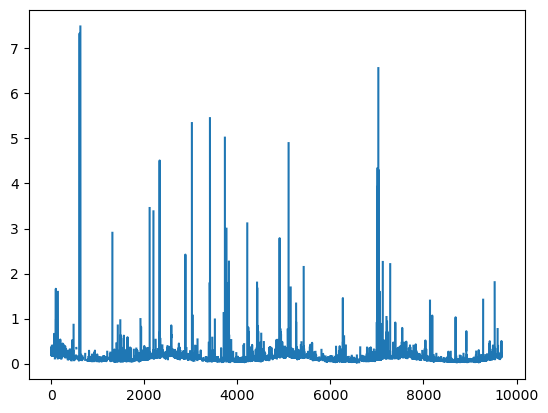

In [7]:
plt.plot(anti_chlor_mean)

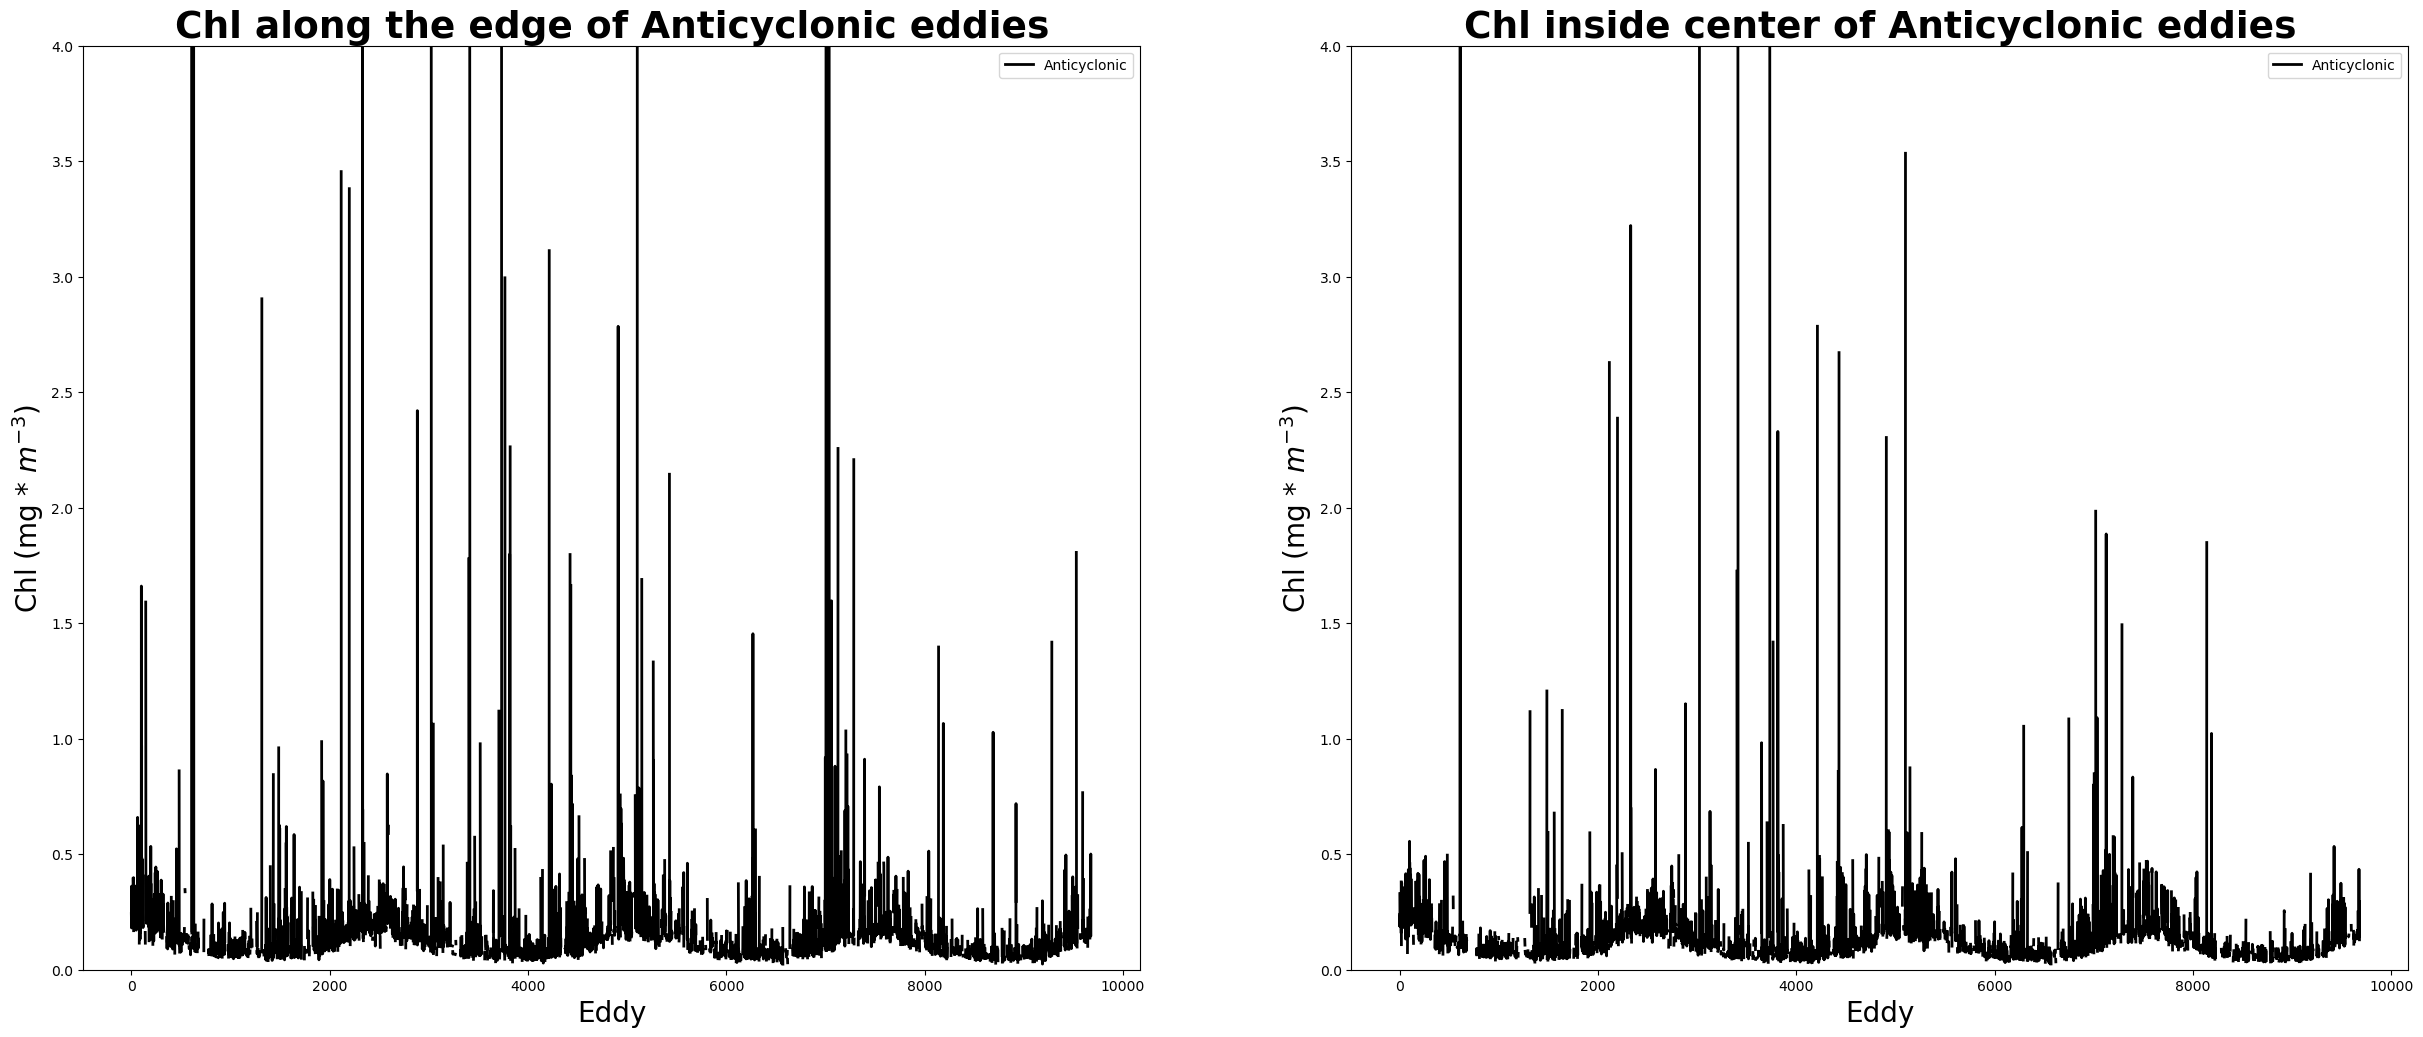

In [15]:
start = dt.datetime(2003,1,1)
new_dates = [start + dt.timedelta(days=i) for i in range(1461)]
#new_dates = [start + dt.timedelta(days=i) for i in range(1094)]
#new_dates_y = [start + dt.timedelta(days=i) for i in range(360)]
#y=new_dates_y
#print(new_dates)

x = new_dates
#x=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
import matplotlib.dates as mdates
xfmt_major=mdates.DateFormatter('\n\n%Y')
xfmt_minor=mdates.DateFormatter('%b')
#xfmt_major=mdates.DateFormatter('%b')
#xfmt_minor=mdates.DateFormatter('%d')
months=mdates.MonthLocator(interval=3)
years=mdates.YearLocator()
#days=mdates.DayLocator(interval=15)
#fig = plt.figure(figsize=(12, 8), dpi=80)
#ax = fig.add_axes([.03,.03,.8,.8])
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(30,12))
#ax1.set_title('Daily-Averaged Mean Chlorophyll within GoM-tuned \nCyclonic eddies (eff contour) from satellite',loc='center',fontsize=15,fontweight='bold')
#ax2.set_title('Daily-Averaged Mean Chlorophyll within GoM-tuned \nAnticyclonic eddies (eff contour) from satellite',loc='center',fontsize=15,fontweight='bold')
#ax1.set_title('Daily-Averaged Mean Phytoplankton Carbon Biomass \nCyclonic eddies (eff contour) from satellite',loc='center',fontsize=15,fontweight='bold')
#ax2.set_title('Daily-Averaged Mean Phytoplankton Carbon Biomass \nAnticyclonic eddies (eff contour) from satellite',loc='center',fontsize=15,fontweight='bold')
#ax1.set_title('Daily-Averaged Mean Net Primary Productivity within \nCyclonic eddies (eff contour) from satellite',loc='center',fontsize=15,fontweight='bold')
#ax2.set_title('Daily-Averaged Mean Net Primary Productivity within \nAnticyclonic eddies (eff contour) from satellite',loc='center',fontsize=15,fontweight='bold')
#ax1.set_title('Daily-Averaged NPP inside Cyclonic eddies',loc='center',fontsize=15,fontweight='bold')
#ax2.set_title('Daily-Averaged NPP inside Anticyclonic eddies',loc='center',fontsize=15,fontweight='bold')
#ax1.set_title('Daily-Averaged Chlorophyll inside Cyclonic eddies',loc='center',fontsize=27,fontweight='bold')
#ax2.set_title('Daily-Averaged Chlorophyll inside Anticyclonic eddies',loc='center',fontsize=27,fontweight='bold')
#ax1.set_title('Daily-Averaged NPP inside entire Anticyclonic eddies',loc='center',fontsize=27,fontweight='bold')
#ax2.set_title('Daily-Averaged NPP along the edge of Anticyclonic eddies',loc='center',fontsize=27,fontweight='bold')
ax2.set_title('Chl inside center of Anticyclonic eddies',loc='center',fontsize=27,fontweight='bold')
ax1.set_title('Chl along the edge of Anticyclonic eddies',loc='center',fontsize=27,fontweight='bold')
#ax1.set_ylim(-3,1)
#ax2.set_ylim(100,700)
#cycl_chlor_mean = np.log(cycl_chlor_mean)
#anti_chlor_mean =  np.log(anti_chlor_mean)
#cycl_chlor_mean[cycl_chlor_mean < 5.7] = np.nan
#anti_chlor_mean[anti_chlor_mean < 5.7] = np.nan
#ax1.plot(x,np.log(cycl_chlor_mean),label='Cyclonic',color='k',lw=2)#,alpha=.5)
#ax1.plot(x,cycl_chlor_mean,label='Cyclonic',color='k',lw=2)#,alpha=.5)
#ax1.plot(x,NPP_center,label='Anticyclonic',color='k',lw=2)#,alpha=.5)
ax1.plot(anti_chlor_mean,label='Anticyclonic',color='k',lw=2)
#ax2.plot(x,np.log(anti_chlor_mean),label='Anticyclonic',color='k',lw=2)#,alpha=.5)
#ax2.plot(x,anti_chlor_mean,label='Anticyclonic',color='k',lw=2)#,alpha=.5)
#ax2.plot(x,NPP_eddy_edge,label='Anticyclonic',color='k',lw=2)#,alpha=.5)
ax2.plot(anti_chlor_mean_center,label='Anticyclonic',color='k',lw=2)
'''
ax3 = ax1.twinx()
ax4 = ax2.twinx()
ax3.plot(x,np.log(cycl_eddies), label='Amplitude',color='red',lw=2)#,alpha=.5)
#ax3.plot(x,anti_eddies.amplitude, label='Amplitude',color='green',lw=2,alpha=.5)
#ax4.plot(x,cycl_eddies.amplitude, label='Amplitude',color='blue',lw=2,alpha=.5)
ax4.plot(x,np.log(anti_eddies), label='Amplitude',color='red',lw=2)#,alpha=.5)
'''
#ax1.vlines(x=['2003-01-01','2004-01-01','2005-01-01','2006-01-01'],
          #ymin=np.nanmin(np.log(cycl_chlor_mean)), ymax=np.nanmax(np.log(cycl_chlor_mean)),colors='k',ls='--',label='New Year')
#ax1.vlines(x=['2003-01-01','2004-01-01','2005-01-01','2006-01-01'],
          #ymin=np.nanmin(cycl_chlor_mean), ymax=np.nanmax(cycl_chlor_mean),colors='k',ls='--',label='New Year')
#ax1.vlines(x=['2003-01-01','2004-01-01','2005-01-01','2006-01-01'],
          #ymin=np.nanmin(NPP_entire_eddy), ymax=np.nanmax(NPP_entire_eddy),colors='k',ls='--',label='New Year')
#ax1.vlines(x=['2003-01-01','2004-01-01','2005-01-01','2006-01-01'],
          #ymin=5.6, ymax=7,colors='k',ls='--',label='New Year')
#ax1.tick_params(axis='y', which='major', labelsize=30)
#ax1.xaxis.set_major_locator(years)
#ax1.xaxis.set_major_formatter(xfmt_major)
#ax1.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
#ax1.xaxis.set_minor_locator(months)
#ax1.xaxis.set_minor_formatter(xfmt_minor)
#plt.setp(ax1.xaxis.get_majorticklabels(),fontsize = 25)
#plt.setp(ax1.xaxis.get_minorticklabels(), rotation=90,fontsize = 25)
#ax1.set_xlabel('Time',fontsize = 20)
ax1.set_xlabel('Eddy',fontsize=20)
ax1.set_ylabel('Chl (mg * $m^{-3}$)',fontsize=20)
#ax1.set_ylabel('log of Chl (mg * $m^{-3}$)',fontsize=25)
#ax1.set_ylabel('Phyto. Cabon Biomass (mg C * $m^{-3}$)',fontsize=15)
#ax1.set_ylabel('log of Phyto. Cabon Biomass (mg C * $m^{-3}$)',fontsize=15)
#ax1.set_ylabel('Net Primary Productivity (mg C * $m^{-2}$ * $day^{-1}$)',fontsize=25)
#ax1.set_ylabel('log of Net Primary Productivity (mg C * $m^{-2}$ * $day^{-1}$)',fontsize=25)
ax1.legend(loc='best')

#ax2.vlines(x=['2003-01-01','2004-01-01','2005-01-01','2006-01-01'],
          #ymin=np.nanmin(np.log(anti_chlor_mean)), ymax=np.nanmax(np.log(anti_chlor_mean)),colors='k',ls='--',label='New Year')
#ax2.vlines(x=['2003-01-01','2004-01-01','2005-01-01','2006-01-01'],
          #ymin=np.nanmin(NPP_eddy_edge), ymax=np.nanmax(NPP_eddy_edge),colors='k',ls='--',label='New Year')
#ax2.vlines(x=['2003-01-01','2004-01-01','2005-01-01','2006-01-01'],
          #ymin=5.6, ymax=7,colors='k',ls='--',label='New Year')
#ax2.tick_params(axis='y', which='major', labelsize=30)
#ax2.xaxis.set_major_locator(years)
#ax2.xaxis.set_major_formatter(xfmt_major)
#ax1.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
#ax2.xaxis.set_minor_locator(months)
#ax2.xaxis.set_minor_formatter(xfmt_minor)
#plt.setp(ax2.xaxis.get_majorticklabels(),fontsize = 25)
#plt.setp(ax2.xaxis.get_minorticklabels(), rotation=90,fontsize = 25)
#ax2.set_xlabel('Time',fontsize = 20)
ax2.set_xlabel('Eddy',fontsize=20)
ax2.set_ylabel('Chl (mg * $m^{-3}$)',fontsize=20)
#ax2.set_ylabel('log of Chl (mg * $m^{-3}$)',fontsize=25)
#ax2.set_ylabel('Phyto. Cabon Biomass (mg C * $m^{-3}$)',fontsize=15)
#ax2.set_ylabel('log of Phyto. Cabon Biomass (mg C * $m^{-3}$)',fontsize=15)
#ax2.set_ylabel('Net Primary Productivity (mg C * $m^{-2}$ * $day^{-1}$)',fontsize=25)
#ax2.set_ylabel('log of Net Primary Productivity (mg C * $m^{-2}$ * $day^{-1}$)',fontsize=15)
ax2.legend(loc='best')
ax1.set_ylim(0,4)
ax2.set_ylim(0,4)
#ax3.set_ylabel('Amplitude (meters)',fontsize=15)
#ax4.set_ylabel('Amplitude (meters)',fontsize=15)
plt.show()